### Biliotecas

In [1]:
import spacy
from spacy.training import Example

import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import re

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import  SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



### Dados

In [2]:
# Link da base de dados: https://www.kaggle.com/yash612/stockmarket-sentiment-dataset
dados = pd.read_csv('stock_data.csv')

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [4]:
dados.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [5]:
dados.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [6]:
dados['Sentiment'].value_counts()

Sentiment
 1    3685
-1    2106
Name: count, dtype: int64

In [7]:
np.unique(dados['Sentiment'], return_counts=True)

(array([-1,  1], dtype=int64), array([2106, 3685], dtype=int64))

<Axes: xlabel='Sentiment', ylabel='count'>

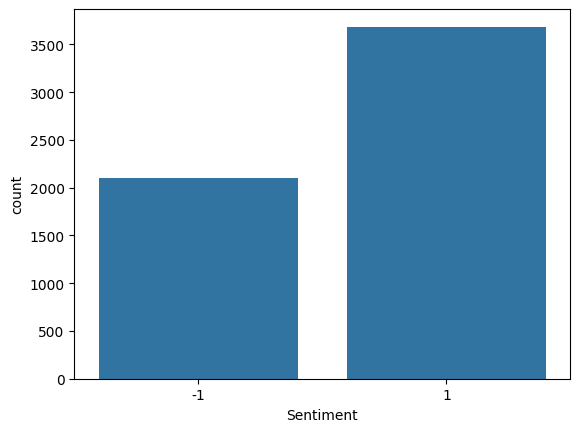

In [8]:
sns.countplot(x = dados['Sentiment'])

### Pré-processamento dos textos

In [9]:
# Escolhemos o "core" do spacy que iremos usar 
pln = spacy.load("en_core_web_md")
pln

In [10]:
# carregramos as stop_Words
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [11]:
print(stop_words)

{'therefore', 'is', 'someone', 'each', 'else', 'as', 'becomes', 'could', 'towards', 'often', 'namely', 'least', 'noone', 'seems', 'ten', 'nine', 'within', 'on', 'toward', 'whenever', 'we', 'where', 'side', 'but', 'see', '‘ve', 'no', 'onto', 'behind', 'many', 'whether', 'further', 'she', 'same', 'elsewhere', "'m", 'three', 'such', 'an', 'too', 'though', 'after', 'others', 'serious', 'whoever', 'my', 'one', 'for', 'afterwards', 'thru', 'under', 'your', 'four', 'wherein', '’re', 'full', 'the', '’m', 'back', 'sometimes', 'while', '’ve', 'across', 'some', 'either', 'move', 'if', 'yourself', 'first', 'at', 'upon', 'once', 'both', 'almost', 'us', 'her', 'anyway', 'am', 'whither', 'here', 'him', 'forty', 'doing', 'hereafter', 'themselves', 'really', 'whereupon', 'somewhere', 'down', 'twelve', 'into', 'using', 'was', 'just', 'whereas', 'whom', 'eight', 'less', 'next', 'how', 'anyone', 'own', 'enough', 'thus', 'he', 'moreover', 'become', 'yours', 'give', 'other', 'why', 'may', "n't", 'eleven', '

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
# Definimos a função para o pré-procesamento de textos

def preprocessamento(texto):
  texto = texto.lower()
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
  texto = re.sub(r" +", ' ', texto)

  documento = pln(texto)
  lista = []
  for token in documento:
    lista.append(token.lemma_)

  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista

In [14]:
# exemplo do preprocesamento 
preprocessamento('I will @test9&+ buy the https://www.iaexpert.academy Apple stock. 9 8 care. caring! car')

'I buy apple stock care care car'

### Pré-processamento da base de dados

In [15]:
dados['Text'] = dados['Text'].apply(preprocessamento)

In [16]:
dados.head()

,Text,Sentiment
0,kicker watchlist xide tit soq pnk cpw bpz aj t...,1
1,user aap movie return fea geed indicator trade...,1
2,user I afraid short amzn look like near monopo...,1
3,mnta 12.00,1
4,oi 21.37,1


In [17]:
dados['tamanho'] = dados['Text'].apply(len)
dados.head()

,Text,Sentiment,tamanho
0,kicker watchlist xide tit soq pnk cpw bpz aj t...,1,74
1,user aap movie return fea geed indicator trade...,1,59
2,user I afraid short amzn look like near monopo...,1,77
3,mnta 12.00,1,10
4,oi 21.37,1,8


In [18]:
dados['tamanho'].describe()

count    5791.000000
mean       48.326196
std        23.985232
min         0.000000
25%        29.000000
50%        48.000000
75%        66.000000
max       129.000000
Name: tamanho, dtype: float64

In [19]:
positivo = dados.loc[dados['Sentiment'] == 1]
positivo['tamanho'].describe()

count    3685.000000
mean       47.494437
std        23.928238
min         0.000000
25%        28.000000
50%        46.000000
75%        65.000000
max       129.000000
Name: tamanho, dtype: float64

In [20]:
negativo = dados.loc[dados['Sentiment'] == -1]
negativo['tamanho'].describe()

count    2106.000000
mean       49.781576
std        24.021106
min         2.000000
25%        30.000000
50%        50.000000
75%        68.000000
max       117.000000
Name: tamanho, dtype: float64

### Nuvem de palavras

In [21]:
textos_positivos = positivo['Text'].tolist()
len(textos_positivos)

3685

In [22]:
textos_positivos[0:10]

['kicker watchlist xide tit soq pnk cpw bpz aj trade method method prev post',
 'user aap movie return fea geed indicator trade year awesome',
 'user I afraid short amzn look like near monopoly ebook infrastructure service',
 'mnta 12.00',
 'oi 21.37',
 'pgnx 3.04',
 'goog ower trend line channel test volume support',
 'aap watch tomorrow ong entry',
 'I assume fcx open tomorrow 34.25 trigger buy like setup',
 'worry I expect market rally usually exact opposite happen time shall soon bac spx jpm']

In [23]:
textos_positivos_string = ' '.join(textos_positivos)
textos_positivos_string

"kicker watchlist xide tit soq pnk cpw bpz aj trade method method prev post user aap movie return fea geed indicator trade year awesome user I afraid short amzn look like near monopoly ebook infrastructure service mnta 12.00 oi 21.37 pgnx 3.04 goog ower trend line channel test volume support aap watch tomorrow ong entry I assume fcx open tomorrow 34.25 trigger buy like setup worry I expect market rally usually exact opposite happen time shall soon bac spx jpm aap gamco arry haverty apple extremely cheap great video user maykiljil post I agree msft high possibly north momentum come etfc break ma200 resistance solid volume friday ong set ha hit 35.65 mean resume target level .. user gameplan shoot today I like trend break c+h break oc weekly trend break july fcx gapping ideal entry look pull open entry user great list particularly like fisv syk buy hold type check free list athx upper trend line ng nice pnf breakout need follow x swing swy float short break ouch biof want 4.90 comin vs i

In [24]:
len(textos_positivos_string)

178701

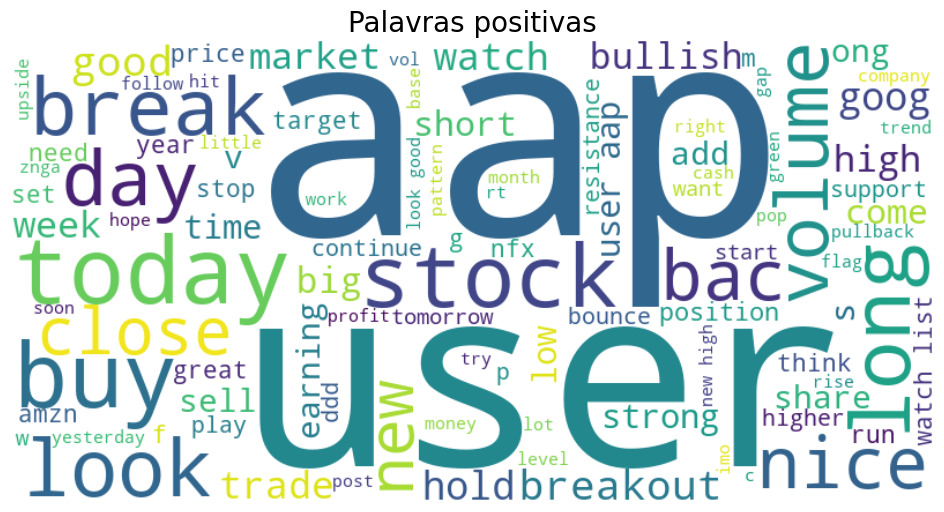

In [25]:
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(textos_positivos_string)


plt.figure(figsize=(12, 6), dpi=100)


plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Palavras positivas", fontsize=20, color='black')
plt.axis("off")  
plt.show()

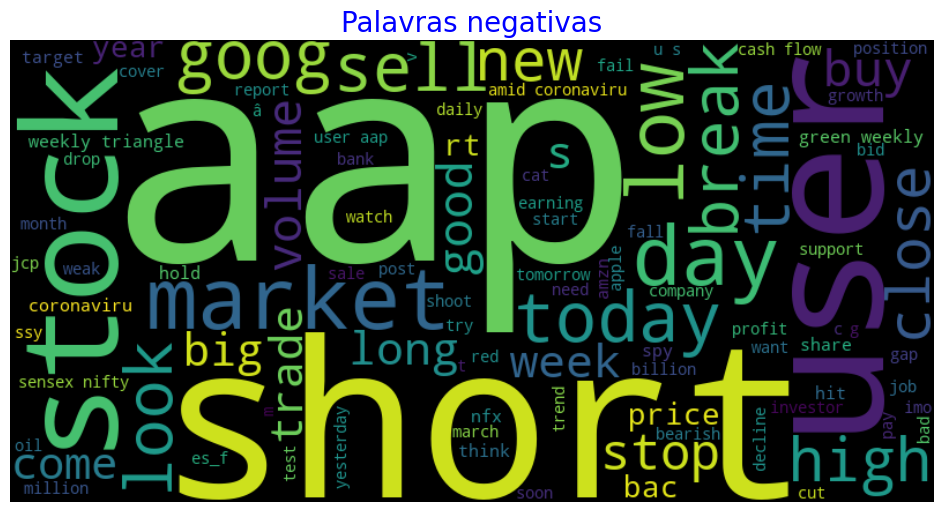

In [26]:
lista_negativo = negativo['Text'].tolist()
textos_negativos_string = ' '.join(lista_negativo)

wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=100).generate(textos_negativos_string)

plt.figure(figsize=(12, 6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Palavras negativas", fontsize=20, color='blue')
plt.axis("off")  
plt.show()

### Entidades nomeadas

https://spacy.io/api/annotation#named-entities

In [27]:
documento = pln(textos_positivos_string)

In [28]:
from spacy import displacy

# displacy.render(documento, style = 'ent', jupyter = True)

In [29]:
empresas_positivas = []
for entidade in documento.ents:
  if entidade.label_ == 'ORG':
    print(entidade.text, entidade.label_)
    empresas_positivas.append(entidade.text)

ong entry ORG
maykiljil post I agree msft ORG
biof ORG
ong stock sbx ORG
apple ORG
axa ORG
kirby daily ORG
atice tade setp ko cnx ORG
aapl daily break ORG
ebay ORG
fnf ORG
fod ORG
aap spx qqq p nbelieveable ORG
ebay v ORG
mastercard ma ORG
oex agnx tv vbd xide ppc exp onty bmn fs wk ORG
ipgp eqix ORG
love wynn ORG
ac ORG
zcs ORG
aapl msft amzn ORG
ema light volume ORG
nvda ORG
kkd krispy kreme doughnuts inc ic xchange ORG
csx ORG
svu ORG
ong aapl daily ORG
amzn daily note ORG
ma ORG
massachusetts state automobile dealer association ORG
awsuit bac trend ORG
setup eqix eqix position ORG
mako fod gnmk jds ege ORG
ni mk ORG
amzn datum company ORG
ford ORG
ford ORG
cbs ORG
zcs ORG
amzn datum company ORG
amazon ORG
pcn ORG
amzn vome big ORG
kos axp ORG
ma ORG
wetf cheap financial stock ORG
nflx session hour ORG
ctxs ORG
mon ORG
aap maco ORG
aig win awsuit ORG
aap egn ocn amh ORG
macd cross signal trade ORG
itstrye ORG
app ORG
ots ORG
ema ORG
swks ORG
apple ORG
ma ipo ORG
geoy ORG
wh ORG
md f

In [30]:
len(empresas_positivas)

698

In [31]:
empresas_positivas = set(empresas_positivas)
len(empresas_positivas)

511

In [32]:
print(empresas_positivas)

{'wmt', 'supprt', 'whenâ€', 'sensex nifty marketupdate', 'abc', 'ong stock vet qdt dcix bs dcth', 'vfc', 'ec', 'sec', 'obin gourmet', 'dxj hd axp csx bac oih bby', 'cnbc', 'amzn free money', 'covid-19 crisis reserve bank india', 'pfmt tts stdy n watch', 'nc corp ed', 'tec', 'nobiano roi bt trade', 'bridgewaterâ€ ™ s', 'canadiangrown', 'partiallyâ€', 'amtd', 'cooper companies inc', 'mar6', 'amd', 'cnn', 'csco state', 'wâ€ ¦ clearlake capital raise', 'nat gas', 'aap aig', 'nyny', 'aig win awsuit', 'oex agnx tv vbd xide ppc exp onty bmn fs wk', 'sca nkd champ', 'nkd giddy aise', 'joe s acm', 'wgo', 'djia spx tx', 'tegra', 'kudo friend', 'fns', 'nited states steel corp option', 'kkd krispy kreme doughnuts inc ic xchange', 'ema', 'korea inc', 'kos axp', 'tandem gme', 'spec dg s tug o war end', 'benchmarke crush', 'mkt', 'stericycle', 'apog cbs enb fgi homb omab saia', 'dva', 'pfe buffet favorite bank cup', 'cmf', 'imi user bac time', 'time!!cnbc', 'econsider', 'aee asgn gmc goog htz nkd po 

In [33]:
empresas_negativas = []
documento = pln(textos_negativos_string)
for entidade in documento.ents:
  if entidade.label_ == 'ORG':
    print(entidade.text, entidade.label_)
    empresas_negativas.append(entidade.text)

bmc aon ORG
nkd ORG
wtw p ORG
aig american international group ORG
sony ORG
sne ORG
aap 50ema ORG
bby ORG
nvda ORG
ma ORG
orange dot traget ORG
ovti ORG
skx q3 ORG
mkt ORG
ipad ORG
zagg green ORG
spx ORG
fio air ORG
www ORG
jemberlin ORG
decine p ORG
hao green ORG
bil mkt ORG
ssys ORG
ttm ORG
wac ORG
ctic ORG
cw clearwire corp arge ORG
p kcg mnta nav ORG
csn ORG
user es spx spy ORG
sm nni msft ORG
mcp crater management ORG
u biz ORG
wsj ORG
ssys ORG
mkt ORG
csn ORG
eason apple ORG
itv ORG
nfx goog amzn early ORG
nfx ise wedge ORG
pdate apple ORG
aap fod ORG
ikely crack demark come ORG
nissan siemens mining ORG
aci ORG
vfc ORG
pdate applesoft ORG
boj ORG
wknd ORG
ibm ORG
compq spx ORG
ballmer number msft mcp short ORG
automotive inc ORG
nfx q3 ORG
mea si macd kdj time ORG
fed ORG
aap apple billion ORG
aap apple ORG
ibm ORG
ft71 ORG
ndx actg ORG
ots gd ORG
y u ORG
aap vxap good vxap ORG
vxap dis bearish ORG
zeno123 ORG
nfx ddd nkd coh sem user aap stop ORG
cboe ORG
gis red bar ORG
red co

In [34]:
empresas_negativas = set(empresas_negativas)
len(empresas_negativas)

292

In [35]:
empresas_positivas_negativas = empresas_positivas.intersection(empresas_negativas)

In [36]:
len(empresas_positivas_negativas)

46

In [37]:
print(empresas_positivas_negativas)

{'axn', 'ibm', 'wells fargo', 'un', 'sensex nifty marketupdate sensex', 'treasury', 'csn', 'ma', 'rbi', 'zcs', 'nvda', 'hâ€', 'deutsche bank', 'morgan stanley', '™', 'comex', 'jcp', 'bby', 'mkt', 'vfc', 'ec', 'sec', '™ s', 'ctic', 'cnbc', '™ s news', 'nkd', 'amazon', 'ipad', 'mon', 'finanâ€', 'pcn', 'aap apple', 'aap', 'ovti', 'marketâ€ ™ s', 'fed', 'eod', 'nj', 'apple', 'h&s', 'odp', 'microsoft', 'goldman sachs', 'dia', 'covid-19'}


### Tratamento base de dados

In [38]:
dados.drop(['tamanho'], axis = 1, inplace = True)

In [39]:
base_treinamento, base_teste = train_test_split(dados, test_size = 0.3, random_state=17)

In [40]:
base_treinamento_final = []
for texto, sentimento in zip(base_treinamento['Text'], base_treinamento['Sentiment']):
  if sentimento == 1:
    dic = ({'POSITIVO': True, 'NEGATIVO': False})
  elif sentimento == -1:
    dic = ({'POSITIVO': False, 'NEGATIVO': True})
  base_treinamento_final.append([texto, dic.copy()])

### Classificador

In [41]:
modelo = spacy.blank('en')
textcat = modelo.add_pipe("textcat")
textcat.add_label('POSITIVO')
textcat.add_label('NEGATIVO')
historico = []

In [42]:
len(base_treinamento_final)

4053

In [43]:
# Treinamento do modelo

modelo.begin_training()
for epoca in range(15):
  random.shuffle(base_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_treinamento_final, 512):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(
            textos, annotations
        )]
    modelo.update(examples, losses=losses)
    historico.append(losses)
  if epoca % 1 == 0:
    print(losses)

{'textcat': 1.8685213029384613}
{'textcat': 1.4404260963201523}
{'textcat': 0.9041777104139328}
{'textcat': 0.4777211584150791}
{'textcat': 0.1946345418691635}
{'textcat': 0.05366780096665025}
{'textcat': 0.01164029045321513}
{'textcat': 0.004173650608208845}
{'textcat': 0.002026689022272876}
{'textcat': 0.0032434045827685054}
{'textcat': 6.688085159911594e-06}
{'textcat': 0.0032741851627005047}
{'textcat': 0.0003189177238366314}
{'textcat': 5.553061419943939e-05}
{'textcat': 0.0056560424693477}


Text(0, 0.5, 'Erro')

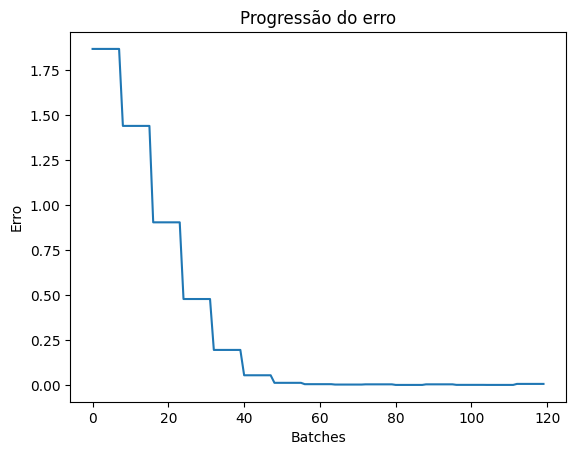

In [44]:
historico_erro = []
for i in historico:
  historico_erro.append(i.get('textcat'))

plt.plot(historico_erro)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

In [45]:
modelo.to_disk('modelo')

### Testes

In [46]:
modelo_carregado = spacy.load('modelo')
modelo_carregado

In [47]:
base_teste.head(10)

,Text,Sentiment
682,I remain convinced apple stock aap year ... se...,1
1370,swi beaut,1
4532,fan,-1
88,amzn near market behave week,1
2976,pa 1.42 pull bit shortage pa ppt great long te...,1
5645,"sensex open point low 26,500 nifty start day 7...",-1
1783,aj start stop,1
3271,bac big volume today big boy involve I,1
1425,p happen october dec slide happen historic ris...,-1
193,chk weekly bullish engulfing,1


#### Positivos

In [48]:
texto_positivo = base_teste['Text'][682]
print(texto_positivo)

previsao = modelo_carregado(texto_positivo)
print(previsao.cats)

I remain convinced apple stock aap year ... sell middle ground
{'POSITIVO': 0.9198924899101257, 'NEGATIVO': 0.08010748773813248}


In [49]:
texto_positivo = base_teste['Text'][2976]
print(texto_positivo)

previsao = modelo_carregado(texto_positivo)
print(previsao.cats)


pa 1.42 pull bit shortage pa ppt great long term outlook swc
{'POSITIVO': 0.9999988079071045, 'NEGATIVO': 1.1629108485067263e-06}


In [50]:
texto_positivo = 'Apple stock is increasing and I will sell for a good price'
texto_positivo = preprocessamento(texto_positivo)

print(texto_positivo)
print(modelo_carregado(texto_positivo).cats)



apple stock increase I sell good price
{'POSITIVO': 0.9999151229858398, 'NEGATIVO': 8.492807683069259e-05}


#### Negativos

In [51]:
texto_negativo = base_teste['Text'][5645]
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'POSITIVO': 3.323567580082454e-05, 'NEGATIVO': 0.9999667406082153}

In [52]:

texto_negativo = base_teste['Text'][4532]
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'POSITIVO': 3.076340959751178e-08, 'NEGATIVO': 1.0}

In [53]:

texto_negativo = base_teste['Text'][1425]
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'POSITIVO': 0.9993165731430054, 'NEGATIVO': 0.0006834144005551934}

### Avaliação do modelo

In [54]:
previsoes = []
for texto in base_teste['Text']:
  #print(texto)
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

len(previsoes)

1738

In [55]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(-1)
previsoes_final = np.array(previsoes_final)

In [56]:
np.unique(previsoes_final)

array([-1,  1])

In [57]:
respostas_reais = base_teste['Sentiment'].values
respostas_reais

array([ 1,  1, -1, ..., -1,  1, -1], dtype=int64)

In [58]:
accuracy_score(respostas_reais, previsoes_final)

0.7387802071346375

In [59]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[406, 217],
       [237, 878]], dtype=int64)

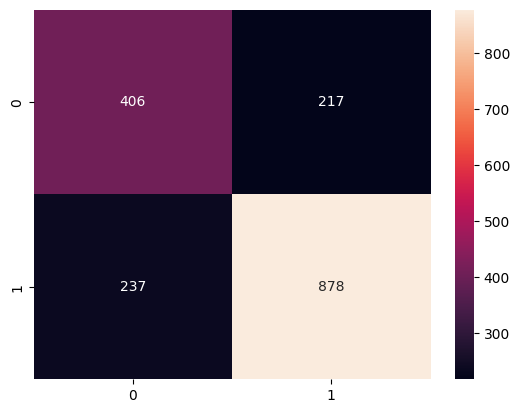

In [60]:
sns.heatmap(cm, annot=True, fmt='d');

In [61]:
print(classification_report(respostas_reais, previsoes_final))

              precision    recall  f1-score   support

          -1       0.63      0.65      0.64       623
           1       0.80      0.79      0.79      1115

    accuracy                           0.74      1738
   macro avg       0.72      0.72      0.72      1738
weighted avg       0.74      0.74      0.74      1738



## Modelo CountVectorizer

In [62]:
dados3 = pd.read_csv('stock_data.csv')


In [63]:
dados3

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [65]:
# Definimos função para o preprocesamento dos dados antes da implementação do modelo

def preprocessamento3(texto):
  texto = texto.lower()
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
  texto = re.sub(f"[{re.escape(string.punctuation)}]", '', texto)
  texto = re.sub('<.*?>','',texto)
  texto = re.sub(r" +", ' ', texto)
  
  return texto



In [66]:
# Aplicamos a função aos dados 

dados3['Text'] = dados3['Text'].apply(preprocessamento3)

In [67]:
dados3

,Text,Sentiment
0,kickers on my watchlist xide tit soq pnk cpw b...,1
1,user aap movie 55 return for the feageed indic...,1
2,user id be afraid to short amzn they are looki...,1
3,mnta over 1200,1
4,oi over 2137,1
...,...,...
5786,industry body cii said discoms are likely to s...,-1
5787,gold prices slip below rs 46000 as investors b...,-1
5788,workers at bajaj auto have agreed to a 10 wage...,1
5789,sharemarket live sensex off day’s high up 600 ...,1


In [68]:
# convertimos as palavras em vetores e criamos o "diccionario de vetores"

count_vec = CountVectorizer(binary=False,max_features=20000)

count_vec_x = count_vec.fit_transform(dados3['Text']).toarray()
count_vec_x = count_vec_x.astype(np.int8)
count_vec_x.shape



(5791, 10948)

In [69]:
# Separando em treino e teste

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(count_vec_x, dados3['Sentiment'], test_size = 0.3, random_state = 17)

In [70]:



sgdclsssifier_model = SGDClassifier(loss='hinge',penalty='l2', alpha=0.001,
                                    l1_ratio=0.15, fit_intercept=True, max_iter=20000,
                                    tol=0.001, shuffle=True, verbose=0, epsilon=0.001, 
                                    n_jobs=None, random_state=17, learning_rate='optimal', 
                                    eta0=0.0, power_t=0.5, early_stopping=False,
                                    validation_fraction=0.1, n_iter_no_change=5,
                                    class_weight=None, warm_start=False, average=False)

sgdclsssifier_model.fit(x_train,y_train)

SGDClassifier(alpha=0.001, epsilon=0.001, max_iter=20000, random_state=17)

In [71]:
print(f'Train score:{format(sgdclsssifier_model.score(x_train,y_train))}')
print(f'Test score:{format(sgdclsssifier_model.score(x_test,y_test))}')

Train score:0.9605230693313594
Test score:0.7658227848101266


In [72]:
import pickle

# Salvar o CountVectorizer
with open('count_vectorizer.pkl', 'wb') as f:
    pickle.dump(count_vec, f)

# Salvar o modelo
with open('sgd_classifier.pkl', 'wb') as f:
    pickle.dump(sgdclsssifier_model, f)

In [73]:
cm3 = confusion_matrix(y_test, sgdclsssifier_model.predict(x_test))


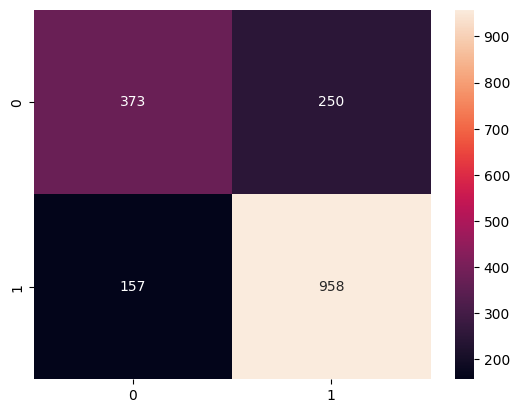

In [74]:
sns.heatmap(cm3, annot=True, fmt='d');

In [75]:
print(classification_report(y_test, sgdclsssifier_model.predict(x_test)))

              precision    recall  f1-score   support

          -1       0.70      0.60      0.65       623
           1       0.79      0.86      0.82      1115

    accuracy                           0.77      1738
   macro avg       0.75      0.73      0.74      1738
weighted avg       0.76      0.77      0.76      1738



### Fazendo uma predição

In [76]:
# guardado o modelo
with open('count_vectorizer.pkl', 'rb') as f:
    count_vec = pickle.load(f)

# abrindo o modelo para implementação 
with open('sgd_classifier.pkl', 'rb') as f:
    sgdc = pickle.load(f)


In [77]:
# Transformar a nova frase
nova_frase = "@carlos say that is a good moment!!!"
nova_frase = preprocessamento3(nova_frase)
nova_frase_vec = count_vec.transform([nova_frase])

# Fazer a predição
predicao = sgdc.predict(nova_frase_vec)
print(predicao)

[1]
